### Logistic Regression with a Neural Network Mindset
#### Build the general architecture of a learning algorithm
1. Initializing Parameters
2. Calculating the cost function and its gradient
3. Using an Optimization algorithm (Gradient Descent)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset

%matplotlib inline

In [3]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()
print("Training Set:", len(train_set_x_orig))
print("Test Set:", len(test_set_x_orig))

Training Set: 209
Test Set: 50


In [4]:
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("\nNumber of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")

train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)


#### Each line of your train_set_x_orig and test_set_x_orig is an array representing an image.

y = [0], it's a 'non-cat' picture.


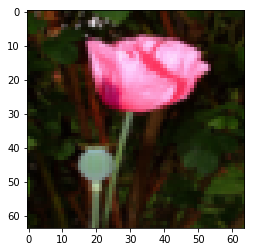

In [5]:
# Example of a picture
index = 30
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

#### Reshape the Training and Test Set

In [6]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


#### Color Image (RGB), three channels must be specified for each pixel, and the pixel value is a vector of three numbers ranging from 0 to 255. 
##### One common preprocessing step in machine learning is to normalize the dataset (substract the mean and divide by the standard deviation of the whole numpy array). For picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

In [7]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

### General Architecture of the learning algorithm

#### Build a Logistic Regression, using a Neural Network mindset. 

Mathematical expression of the algorithm:

For one example $x^{(i)}$: $$z^{(i)} = w^T x^{(i)} + b \tag{1}$$ $$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ $$ \mathcal{L}(a^{(i)}, y^{(i)}) = - y^{(i)} \log(a^{(i)}) - (1-y^{(i)} ) \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples: $$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

Key steps: In this exercise, you will carry out the following steps:

- Initialize the parameters of the model
- Learn the parameters for the model by minimizing the cost  
- Use the learned parameters to make predictions (on the test set)
- Analyse the results and conclude

#### Helper Functions

In [8]:
def sigmoid(z):
    s = 1/(1+1/np.exp(z))
    return s

print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


In [9]:
# Initialize Parameters with zeros
# This function creats a vector of zeros of shape (dim, 1) for w and initializes b (bias) to 0.

def initialize_with_zeros(dim):
    """
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    """
    
    w = np.zeros(shape = (dim,1))
    b = 0
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


### Forward and Backward propagation steps for learning the parameters.

Forward Propagation:
Here are the two formulas:
$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$



In [10]:
def propagate(w, b, X, Y):
    """
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T, X)+b)                        # compute activation
    cost = -1.0/m*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))  # compute cost 
        
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = 1.0/m*np.dot(X, (A-Y).T)
    db = 1.0/m*np.sum(A-Y)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

w, b, X, Y = np.array([[1],[2]]), 2, np.array([[1,2],[3,4]]), np.array([[1,0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99993216]
 [1.99980262]]
db = 0.49993523062470574
cost = 6.000064773192205


### Optimization

Optimization function to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [11]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    
    costs = []
    
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y) 
        dw = grads["dw"]
        db = grads["db"]
        w = w - learning_rate*dw
        b = b - learning_rate*db
 
        if i % 100 == 0:
            costs.append(cost)
        
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.1124579 ]
 [0.23106775]]
b = 1.5593049248448891
dw = [[0.90158428]
 [1.76250842]]
db = 0.4304620716786828


### Computing Prediction:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$
2. Convert the entries into 0 (if activation <= 0.5) or 1 (if activation > 0.5), and stores the predictions in a vector Y_prediction. 

In [12]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        Y_prediction[0, i] = 0 if A[0, i] <= 0.5 else 1 
   
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1.]]


### Merge all above function and build final Model

In [13]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):

    # initialize parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent 
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost = False)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples 
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [14]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


In [15]:
d["Y_prediction_test"]

array([[1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1.,
        0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1.,
        1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
        1., 0.]])

y = 1, you predicted that it is a "


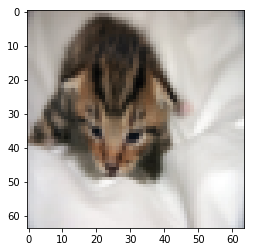

In [16]:
# Example of a picture that was wrongly classified.
index = 1
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
# print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[d["Y_prediction_test"][0,index]].decode("utf-8") +  "\" picture.")
print("y = " + str(test_set_y[0,index])+", you predicted that it is a \"")

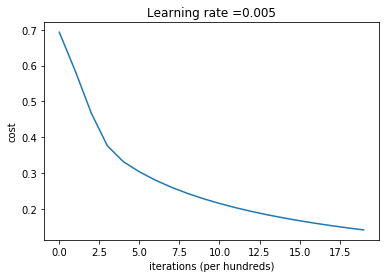

In [17]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

#### Choice of Learning Rate

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



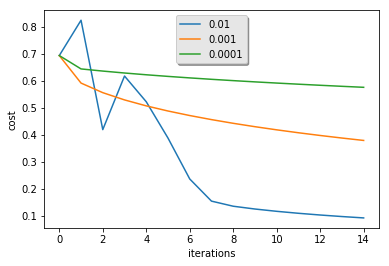

In [18]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

#### Interpretation:
Different learning rates give different costs and thus different predictions results.
1. If the learning rate is too large (0.01), the cost may oscillate up and down. It may even diverge.
2. A lower cost doesn't mean a better model. There is a possibly of overfitting. 
    In deep learning, we usually recommend that you:
        Choose the learning rate that better minimizes the cost function.


### Test with your own Image

In [ ]:
my_image = "my_image.jpg"

# Preprocess the image to fit the algorithm.
fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")